In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/real-estate-price-prediction-moscow/sample_submission.csv
/kaggle/input/real-estate-price-prediction-moscow/test.csv
/kaggle/input/real-estate-price-prediction-moscow/train.csv


In [2]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.manifold import TSNE
from sklearn.linear_model import LinearRegression

from sklearn.cluster import KMeans

from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from pylab import rcParams

In [3]:
from datetime import date

### 1. Необходимые функции и пути

In [4]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

In [5]:
TRAIN_DATASET_PATH = '/kaggle/input/real-estate-price-prediction-moscow/train.csv'
TEST_DATASET_PATH = '/kaggle/input/real-estate-price-prediction-moscow/test.csv'

train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

In [6]:
train_df['HouseFloor'].mean()

12.6094

### 2. Обработка выбросов

In [7]:
class DataPreprocessing:

# Id - идентификационный номер квартиры
# DistrictId - идентификационный номер района
# Rooms - количество комнат
# Square - площадь
# LifeSquare - жилая площадь
# KitchenSquare - площадь кухни
# Floor - этаж
# HouseFloor - количество этажей в доме
# HouseYear - год постройки дома
# Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности
# Social_1, Social_2, Social_3 - социальные показатели местности
# Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья
# Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров
# Price - цена квартиры

    def __init__(self):
        """Параметры класса"""
        self.medians=None
        self.kitchen_square_quantile = None
        
    def fit(self, X):
        """Сохранение статистик"""       
        # Расчет медиан
        self.medians = X.median()
        self.kitchen_square_quantile = X['KitchenSquare'].quantile(.975)
    
    def transform(self, X):
        """Трансформация данных"""

        # Rooms
        X['Rooms_outlier'] = 0
        X.loc[(X['Rooms'] == 0) | (X['Rooms'] >= 6), 'Rooms_outlier'] = 1
        
        X.loc[X['Rooms'] == 0, 'Rooms'] = 1
        X.loc[X['Rooms'] >= 4, 'Rooms'] = self.medians['Rooms']
        
        # Square, LifeSquare, KitchenSquare
        
        X['Square_outlier'] = 0
        X.loc[(X['Square'] == 0) | (X['Square'] <= 8) | (X['Square'] >= 900), 'Square_outlier'] = 1
        
        condition = (X['KitchenSquare'].isna()) | (X['KitchenSquare'] > self.kitchen_square_quantile)
        
        X.loc[condition, 'KitchenSquare'] = self.medians['KitchenSquare']
        X.loc[X['KitchenSquare'] < 3 , 'KitchenSquare'] = X['Square'] 
        X.loc[X['KitchenSquare'] > 0.5*X['Square'], 'KitchenSquare'] = 0.3*X['Square'] #исключает слишком большую, относительно размеров квартиры, кухню
        
        X.loc[X['LifeSquare'] > X['Square'], 'LifeSquare'] = X['Square'] - X['KitchenSquare'] - 0.2*X['Square'] #0.2*X['Square'] на прочие удобства квартиры 
        
        # HouseFloor, Floor
        
        X['HouseFloor_outlier'] = 0
        X.loc[X['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
        X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor_outlier'] = 1
        
        X.loc[X['HouseFloor'] == 0, 'HouseFloor'] = self.medians['HouseFloor']
        
        X.loc[X['Floor'] > X['HouseFloor'], 'Floor'] = X['HouseFloor']
        
        # HouseYear

        current_year = datetime.now().year
        
        X['HouseYear_outlier'] = 0
        X.loc[X['HouseYear'] > current_year, 'HouseYear_outlier'] = 1
        
        X.loc[X['HouseYear'] > current_year, 'HouseYear'] = current_year
        
        # Healthcare_1
        if 'Healthcare_1' in X.columns:
            X.drop('Healthcare_1', axis=1, inplace=True)
        
        X.fillna(self.medians, inplace=True)
        
        return X

### 3. Генерация фичей

In [8]:
class FeatureGenetator():
    """Генерация новых фич"""
    
    def __init__(self):
        self.DistrictId_counts = None
        self.binary_to_numbers = None
        self.med_price_by_district = None
        self.med_price_by_district_room = None
        self.med_price_by_floor = None
        self.med_price_by_square = None
        self.med_price_by_rooms_kitchen = None
        self.house_year_max = None
        self.floor_max = None
        self.square_max = None
        self.lifesquare_max = None
        self.kitchensquare_max = None
        self.housefloor_max = None        
        
    def fit(self, X, y=None):
        
        X = X.copy()
        
        # Binary features
        self.binary_to_numbers = {'A': 0, 'B': 1}
        
        # DistrictID
        self.district_size = X['DistrictId'].value_counts().reset_index() \
                               .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
                
        # Target encoding
        ## District, year
        df = X.copy()
        
        if y is not None:
            self.house_year_max = df['HouseYear'].max()
            df['Price'] = y.values
            df = self.year_to_cat(df)
            self.med_price_by_district = df.groupby(['DistrictId', 'year_cat'], as_index=False).agg({'Price':'median'})\
                                            .rename(columns={'Price':'MedPriceByDistrict'})
            self.med_price_by_district_median = self.med_price_by_district['MedPriceByDistrict'].median()
        
        ##district, room
        if y is not None:
            df['Price'] = y.values
            self.med_price_by_district_room = df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                                            .rename(columns={'Price':'MedPriceByDistrictRoom'})
            self.med_price_by_district_room_median = self.med_price_by_district_room['MedPriceByDistrictRoom'].median()
        
        ## floor, housefloor
        if y is not None:
            self.floor_max = df['Floor'].max()
            self.housefloor_max = df['HouseFloor'].max()
            df['Price'] = y.values
            df = self.floor_to_cat(df)
            df = self.housefloor_to_cat(df)
            self.med_price_by_floor = df.groupby(['housefloor_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloor'})
            self.med_price_by_floor_median = self.med_price_by_floor['MedPriceByFloor'].median()
        
        ## square - оценка стоимости относительно размеров квартиры и жилой площади квартиры
        if y is not None:
            self.square_max = df['Square'].max()
            self.lifesquare_max = df['LifeSquare'].max()
            df['Price'] = y.values
            df = self.square_to_cat(df)
            df = self.lifesquare_to_cat(df)
            self.med_price_by_square = df.groupby(['square_cat', 'lifesquare_cat'], as_index=False).agg({'Price':'median'})\
                                            .rename(columns={'Price':'MedPriceBySquare'})
            self.med_price_by_square_median = self.med_price_by_square['MedPriceBySquare'].median()
        
        ## Room, kitchensquare
        if y is not None:
            self.kitchensquare_max = df['KitchenSquare'].max()
            df['Price'] = y.values
            df = self.kitchensquare_to_cat(df)
            self.med_price_by_rooms_kitchen = df.groupby(['Rooms', 'kitchensquare_cat'], as_index=False).agg({'Price':'median'})\
                                            .rename(columns={'Price':'MedPriceByRoomsKitchen'})
            self.med_price_by_rooms_kitchen_median = self.med_price_by_rooms_kitchen['MedPriceByRoomsKitchen'].median()


        
    def transform(self, X):
        
        # Binary features
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)  # self.binary_to_numbers = {'A': 0, 'B': 1}
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)
        
        # DistrictId, IsDistrictLarge
        X = X.merge(self.district_size, on='DistrictId', how='left')
        
        X['DistrictSize'].fillna(5, inplace=True)
        
        X['IsDistrictLarge'] = (X['DistrictSize'] > 100).astype(int)
        
        # More categorical features
        X = self.floor_to_cat(X)                 # + столбец floor_cat
        X = self.year_to_cat(X)                  # + столбец year_cat
        X = self.square_to_cat(X)                # + столбец square_cat
        X = self.lifesquare_to_cat(X)            # + столбец lifesquare_cat   
        X = self.kitchensquare_to_cat(X)         # + столбец kitchensquare_cat
        X = self.housefloor_to_cat(X)            # + столбец housefloor_cat
        
        # Target encoding
        if self.med_price_by_district is not None:
            X = X.merge(self.med_price_by_district, on=['DistrictId', 'year_cat'], how='left')
            X.fillna(self.med_price_by_district_median, inplace=True)
            
        if self.med_price_by_district_room is not None:
            X = X.merge(self.med_price_by_district_room, on=['DistrictId', 'Rooms'], how='left')
            X.fillna(self.med_price_by_district_room_median, inplace=True)
            
        if self.med_price_by_rooms_kitchen is not None:
            X = X.merge(self.med_price_by_rooms_kitchen, on=['Rooms','kitchensquare_cat'], how='left')
            X.fillna(self.med_price_by_rooms_kitchen_median, inplace=True)
                    
        if self.med_price_by_square is not None:
            X = X.merge(self.med_price_by_square, on=['square_cat', 'lifesquare_cat'], how='left')
            X.fillna(self.med_price_by_square_median, inplace=True)

        if self.med_price_by_floor is not None:
            X = X.merge(self.med_price_by_floor, on=['housefloor_cat', 'floor_cat'], how='left')
            X.fillna(self.med_price_by_floor_median, inplace=True)
        
        return X
    
    def floor_to_cat(self, X):
        bins = [0, 3, 5, 9, 15, self.floor_max]
        X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)

        X['floor_cat'].fillna(-1, inplace=True) 
        return X
     
    def year_to_cat(self, X):
        bins = [0, 1941, 1945, 1980, 2000, 2010, self.house_year_max]
        X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)

        X['year_cat'].fillna(-1, inplace=True)
        return X
    
    def square_to_cat(self, X):
        bins = [0, 30, 80, 150, 300, 500, self.square_max]
        X['square_cat'] = pd.cut(X['Square'], bins=bins, labels=False)

        X['square_cat'].fillna(-1, inplace=True)
        return X
    
    def lifesquare_to_cat(self, X):
        bins = [0, 10, 60, 100, 250, 400, self.lifesquare_max]
        X['lifesquare_cat'] = pd.cut(X['LifeSquare'], bins=bins, labels=False)

        X['lifesquare_cat'].fillna(-1, inplace=True)
        return X
    
    def kitchensquare_to_cat(self, X):
        bins = [0, 5, 40, 80, self.kitchensquare_max]
        X['kitchensquare_cat'] = pd.cut(X['KitchenSquare'], bins=bins, labels=False)

        X['kitchensquare_cat'].fillna(-1, inplace=True)
        return X
    
    def housefloor_to_cat(self, X):
        bins = [0, 5, 20, 40, self.housefloor_max]
        X['housefloor_cat'] = pd.cut(X['HouseFloor'], bins=bins, labels=False)

        X['housefloor_cat'].fillna(-1, inplace=True)
        return X
        

In [9]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

preprocessor = DataPreprocessing()
preprocessor.fit(train_df)

train_df = preprocessor.transform(train_df)
test_df = preprocessor.transform(test_df)
train_df.shape, test_df.shape

((10000, 23), (5000, 22))

In [10]:
features_gen = FeatureGenetator()
features_gen.fit(train_df.drop(columns='Price'), train_df['Price'])

train_df = features_gen.transform(train_df)
test_df = features_gen.transform(test_df)
train_df.shape, test_df.shape

((10000, 36), (5000, 35))

In [11]:
train_df.isna().sum().sum(), test_df.isna().sum().sum()

(0, 0)

### 4. Отбор признаков

In [12]:
# feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
#                  'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1',
#                  'Helthcare_2', 'Shops_1']

# new_feature_names = ['Rooms_outlier', 'HouseFloor_outlier', 'HouseYear_outlier', 'DistrictSize',
#                       'IsDistrictLarge',  'MedPriceByDistrict', 'MedPriceByFloorYear', 'MedPriceBySquare']

feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                  'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1',
                  'Helthcare_2', 'Shops_1']

new_feature_names = ['HouseFloor_outlier', 'DistrictSize', 'MedPriceByDistrict', 'MedPriceByDistrictRoom', 'MedPriceByFloor', 'MedPriceBySquare', 
                     'MedPriceByRoomsKitchen']


target_name = 'Price'

### 5. Разбиение на train и test

In [13]:
X = train_df[feature_names + new_feature_names]
y = train_df[target_name]

test_df = test_df[feature_names + new_feature_names]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=21)

### 6. Построение модели

In [14]:
rf_model = RandomForestRegressor(random_state=21, criterion='mse')
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=21)

Train R2:	0.966
Test R2:	0.76


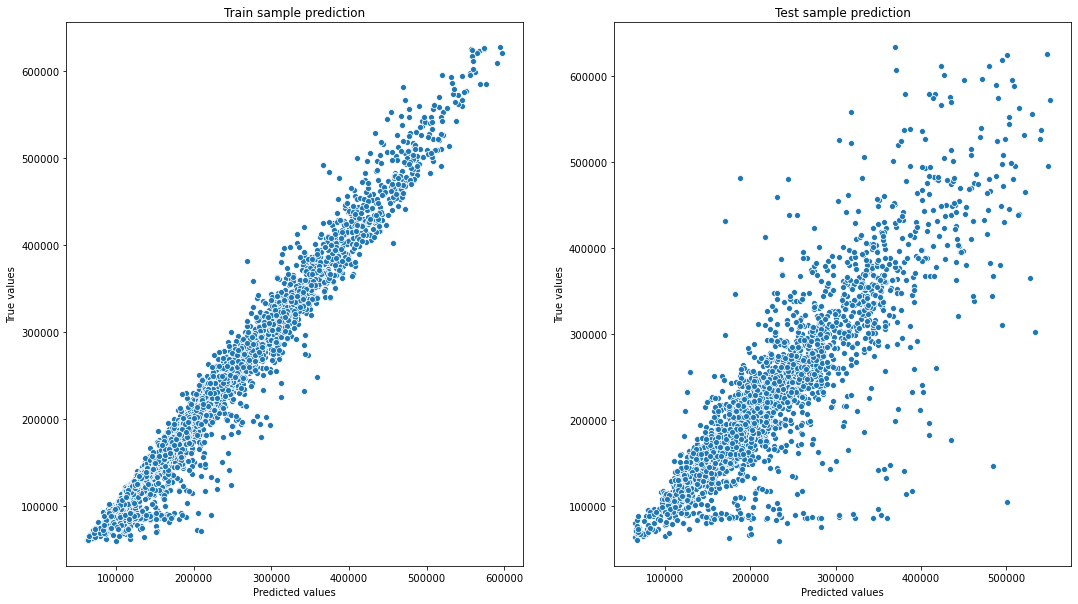

In [15]:
y_train_preds = rf_model.predict(X_train)
y_test_preds = rf_model.predict(X_test)

evaluate_preds(y_train, y_train_preds, y_test, y_test_preds)

In [16]:
cv_score = cross_val_score(rf_model, X, y, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=21))
cv_score

array([0.75902829, 0.73931765, 0.7867616 ])

In [17]:
cv_score.mean()

0.7617025134160418

In [18]:
feature_importances = pd.DataFrame(zip(X_train.columns, rf_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
16,MedPriceByDistrictRoom,0.528076
1,Square,0.157167
15,MedPriceByDistrict,0.124604
3,KitchenSquare,0.025050
2,LifeSquare,0.023850
6,HouseYear,0.023506
10,Social_1,0.020694
14,DistrictSize,0.016856
4,Floor,0.014746
7,Ecology_1,0.014138


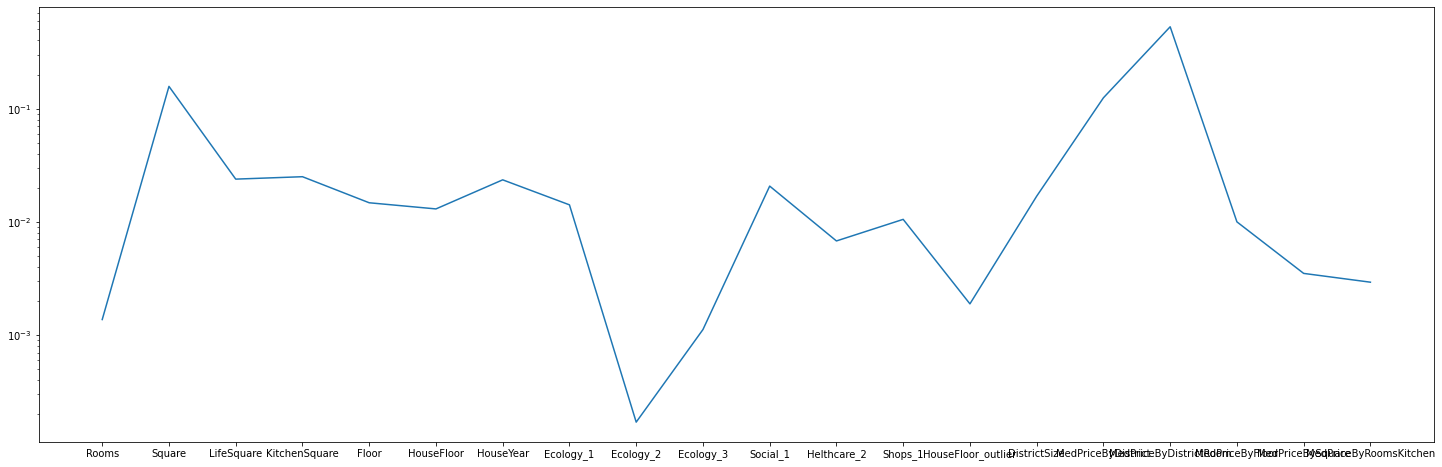

In [19]:
rcParams["figure.figsize"] = 25, 8

plt.plot(feature_names+new_feature_names, rf_model.feature_importances_)
plt.yscale(value="log")
plt.show()

In [20]:
cv_score = cross_val_score(rf_model, X, y, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=21))
cv_score

array([0.75902829, 0.73931765, 0.7867616 ])

In [21]:
cv_score.mean()

0.7617025134160418

In [22]:
feature_importances = pd.DataFrame(zip(X_train.columns, rf_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
16,MedPriceByDistrictRoom,0.528076
1,Square,0.157167
15,MedPriceByDistrict,0.124604
3,KitchenSquare,0.025050
2,LifeSquare,0.023850
6,HouseYear,0.023506
10,Social_1,0.020694
14,DistrictSize,0.016856
4,Floor,0.014746
7,Ecology_1,0.014138


### 7. Прогнозирование

In [23]:
test_df.head()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Helthcare_2,Shops_1,HouseFloor_outlier,DistrictSize,MedPriceByDistrict,MedPriceByDistrictRoom,MedPriceByFloor,MedPriceBySquare,MedPriceByRoomsKitchen
0,1.0,36.847630,19.094182,5.000000,5.0,9.0,1970,0.036122,1,1,24,1,1,0,104.0,190200.806033,171145.169069,195114.173473,186084.069628,154030.205137
1,1.0,42.493907,23.995126,10.000000,7.0,17.0,2017,0.072158,1,1,2,0,0,0,247.0,156419.550709,129107.218932,197826.661941,186084.069628,155120.084521
2,2.0,59.463678,32.781260,9.000000,19.0,19.0,1977,0.211401,1,1,9,0,1,0,851.0,145436.023704,166268.959295,192054.229594,186084.069628,206507.108185
3,3.0,49.646030,33.893825,6.000000,2.0,2.0,1965,0.014073,1,1,2,0,0,0,565.0,117557.136022,166687.735824,179505.786361,186084.069628,278970.795628
4,1.0,53.837056,32.781260,16.151117,8.0,17.0,1977,0.309479,1,1,35,0,6,0,114.0,195389.936837,165071.825722,197826.661941,186084.069628,155120.084521


In [24]:
submit = pd.read_csv('/kaggle/input/real-estate-price-prediction-moscow/sample_submission.csv')
submit.head()

,Id,Price
0,4567,200000.0
1,5925,200000.0
2,960,200000.0
3,3848,200000.0
4,746,200000.0


In [25]:
predictions = rf_model.predict(test_df)
predictions

array([164841.63937437, 124387.48658987, 136110.60796621, ...,
       151733.8189274 , 183106.45240211, 281281.40400514])

In [26]:
submit['Price'] = predictions
submit.head()

,Id,Price
0,4567,164841.639374
1,5925,124387.486590
2,960,136110.607966
3,3848,136758.659272
4,746,184581.499815


In [27]:
submit.to_csv('rf_submit.csv', index=False)